# ACP stations

## Import the ACP data

In [1]:
import pandas as pd
import xarray as xr
import cf_xarray.units  # noqa F401
import pint_xarray  # noqa F401

from weatherforce.datasources.catalogue import Catalogue
from weatherforce.datasources.pathfinder import DATA_DIR


class AcpStationSource:
    def open_time_range(self, start=None, end=None, units=False):
        """
        Open data for the given time range. If neither start or end are given all existing data will be returned.

        Args:
            start: Start of the time range. By default is None, which will return all the data from the first existing
                file.
            end: End of the time range. By default is None, which will take the data until the last existing file.
            units: Quantify pint units from metadata
        Returns:
            dataset containing the station data for the given time range.
            """
        filepaths = self._get_filepaths_in_time_range(start, end)
        ds = xr.open_mfdataset(filepaths)
        ds = ds.sel(time=slice(start, end))
        if units:
            ds = units = ds.pint.quantify()
        return ds

    def catalogue_url(self):
        """ Return the url of the catalogue source """
        return f"https://hub.weatherforce.net/manager/catalogue/sources/{self.source_id}"

    def _assert_valid_start(self, start, assets):
        if pd.Timestamp(start, tz="UTC") < assets.index.min(): # I think the station data is in UTC but to be checked
            self.log.warning(f"Start time is smaller than the minimum existing time: {assets.index.min()}")

    def _assert_valid_end(self, end, assets):
        if assets.index.max() < pd.Timestamp(end, tz="UTC"): # I think the station data is in UTC but to be checked
            self.log.warning(f"End time is bigger than the maximum existing time: {assets.index.max()}")

    def _get_filepaths_in_time_range(self, start, end):
        # After the new weather notebook image release this fuction must be replaced by the
        # Catalogue().list_time_sorted_source_assets method
        assets = self.list_time_sorted_catalogue_source_assets(self.source_id)
        self._assert_valid_start(start, assets)
        self._assert_valid_end(end, assets)
        assets_in_time_range = self._select_assets_in_range(assets, start, end)
        return self._get_assets_absolute_filepath(assets_in_time_range)
    
    def _select_assets_in_range(self, assets, start, end):
        assets_in_time_range = assets.loc[:end]
        if start is None:
            return assets_in_time_range
        else:
            return assets_in_time_range[start <= assets_in_time_range["values_end_time"]]
    
    def _get_assets_absolute_filepath(self, assets):
        return [DATA_DIR / file for file in assets.path]


    def list_time_sorted_catalogue_source_assets(self, source_id: str) -> pd.DataFrame:
        """
        Return a pandas dataframe with the assets of the catalogue
        ordered according to their start-values.

        It always renders a dataframe, even if there are no
        assets associated with the source. The dataframe is just
        empty.

        Args:
            source_id: Identifier of the catalogue data source

        Returns:
            An ordered pd.DataFrame of assets
        """

        assets = Catalogue().list_source_assets(source_id)

        number_assets = len(assets)

        if len(assets) == 0:
            assets = {"values_start_time": [],
                      "path": [],
                      "values_end_time": [],
                      "produced_at": [],
                      "source_id": []}

        assets = pd.DataFrame.from_dict(assets)
        assets["values_start_time"] = pd.to_datetime(assets["values_start_time"])

        time_ordered_assets = assets.set_index("values_start_time").sort_index()

        if not len(time_ordered_assets.index.unique()) == number_assets:
            raise ValueError("Cannot create the pandas dataframe without removing assets",
                             "as two or more assets share the same value",
                             "start time used as index. Use `list_source_assets` method instead.")

        return time_ordered_assets


class AcpF5Daily(AcpStationSource):
    def __init__(self, logger=None):
        self.source_id = "5302aa35-c98f-450f-a2b4-f87c38759cdb"


class AcpF7Daily(AcpStationSource):
    def __init__(self, logger=None):
        self.source_id = "002b6c65-64fe-4234-90bb-ddfba80f3ba0"

# Open F5 station all data
ds1 = AcpF5Daily().open_time_range()

# Open F7 station all data with units
ds2 = AcpF7Daily().open_time_range()

## ACP F5 station

In [2]:
ds1.load()
print(f'Data from {ds1.time.min().values} to {ds1.time.max().values}.')
ds1.tp

Data from 2017-04-20T00:00:00.000000000 to 2023-04-24T00:00:00.000000000.


<xarray.DataArray 'tp' (time: 2187)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-20 2017-04-21 ... 2023-04-24
Attributes:
    units:    mm

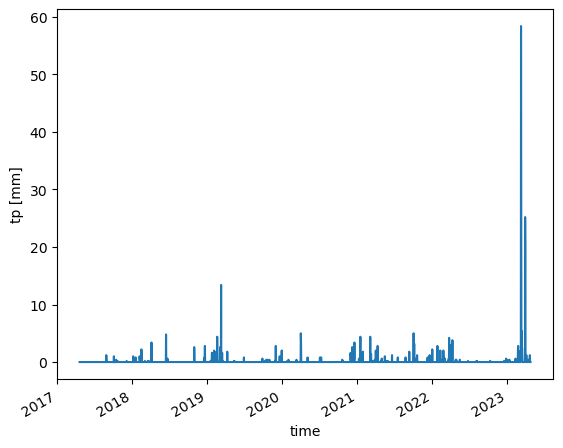

In [3]:
ds1.tp.plot()

In [7]:
res = ds1.tp.resample(time='M').sum()

In [8]:
res

<xarray.DataArray 'tp' (time: 73)>
array([  0.       ,   0.       ,   0.       ,   0.       ,   1.8000001,
         0.       ,   1.8000001,   0.       ,   0.2      ,   2.       ,
         5.2000003,   0.6      ,   3.8000002,   0.       ,   5.4      ,
         0.       ,   0.       ,   0.       ,   4.2      ,   0.       ,
         5.2000003,   3.2      ,  13.       ,  19.4      ,   1.8      ,
         0.4      ,   0.8      ,   0.       ,   0.       ,   1.       ,
         1.4      ,   0.2      ,   6.6      ,   0.2      ,   0.4      ,
         1.       ,   8.6      ,   0.8      ,   0.       ,   1.6      ,
         0.       ,   0.       ,   1.       ,   2.2      ,   8.2      ,
         9.6      ,   0.       ,   7.       ,   7.7999997,   1.4000001,
         1.2      ,   0.8      ,   0.8      ,   2.       ,  11.6      ,
         0.       ,   2.2      ,   5.       ,   5.4000006,   9.2      ,
         8.       ,   0.4      ,   0.2      ,   0.       ,   0.4      ,
         0.       ,   0.4      ,   0.       ,   0.8      ,   1.2      ,
         6.4000006, 140.4      ,   4.       ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-30 2017-05-31 ... 2023-04-30
Attributes:
    units:    mm

In [12]:
tp_monthly_mean = res.groupby('time.month').mean(dim='time')

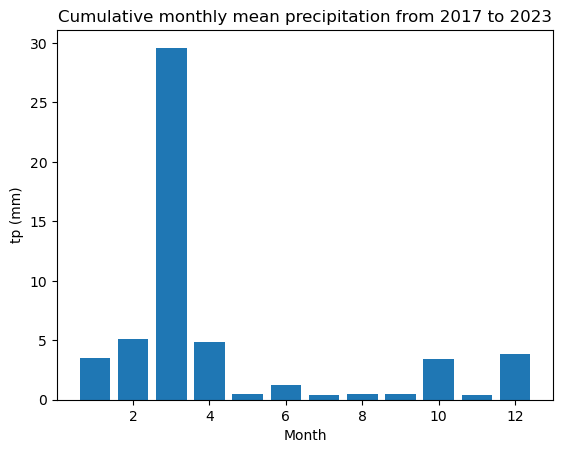

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(tp_monthly_mean['month'], tp_monthly_mean)
plt.xlabel('Month')
plt.ylabel('tp (mm)')
plt.title('Cumulative monthly mean precipitation from 2017 to 2023')
plt.show()

Percentage of NaN values in the 'tp' data: 0.32 % 



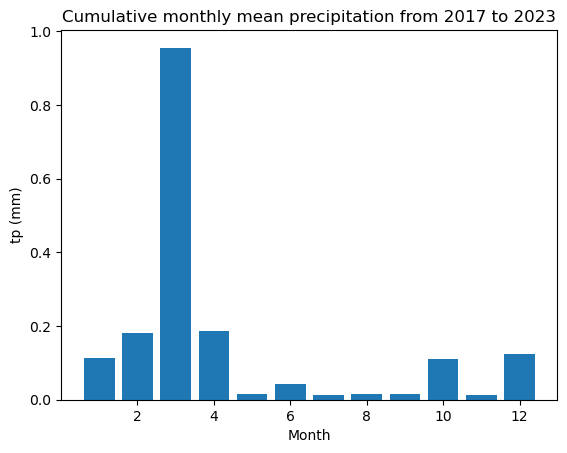

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Percentage of NaN values in 'tp'
count_nan = np.isnan(ds1['tp']).sum()
count_all = ds1['tp'].count()
print("Percentage of NaN values in the 'tp' data:", "%.2f" % (100 * count_nan/count_all), "% \n")

# Group the data by month and compute the mean
tp_monthly_mean = ds1['tp'].groupby('time.month').mean(dim='time')
tp_monthly_mean_ds = tp_monthly_mean.to_dataframe()
tp_monthly_mean_ds.to_csv(f'tp_month_mean_2017_2023_ACP_F5.csv')


# Create the bar plot
fig = plt.figure()
plt.bar(tp_monthly_mean['month'], tp_monthly_mean)
plt.xlabel('Month')
plt.ylabel('tp (mm)')
plt.title('Cumulative monthly mean precipitation from 2017 to 2023')
plt.show()

fig.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/ACP/figures/tp_month_mean_ACP_F5.png')

## ACP F7 station

In [6]:
ds2.load()
print(f'Data from {ds2.time.min().values} to {ds2.time.max().values}.')
ds2.tp

Data from 2008-01-01T00:00:00.000000000 to 2023-04-24T00:00:00.000000000.


<xarray.DataArray 'tp' (time: 5560)>
array([0.4, 0. , 0. , ..., 0. , 0. , 0. ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2023-04-24
Attributes:
    units:    mm

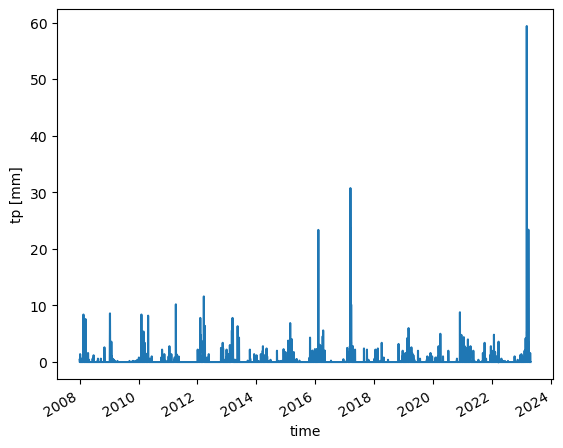

In [7]:
ds2.tp.plot()

Percentage of NaN values in the 'tp' data: 0.45 % 



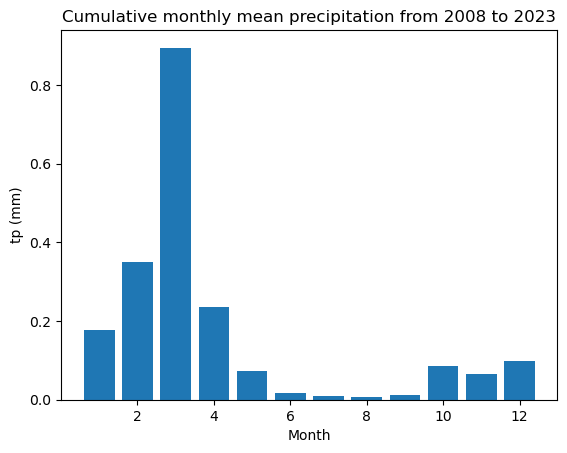

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Percentage of NaN values in 'tp'
count_nan = np.isnan(ds2['tp']).sum()
count_all = ds2['tp'].count()
print("Percentage of NaN values in the 'tp' data:", "%.2f" % (100 * count_nan/count_all), "% \n")

# Group the data by month and compute the mean
tp_monthly_mean = ds2['tp'].groupby('time.month').mean(dim='time')
tp_monthly_mean_ds = tp_monthly_mean.to_dataframe()
tp_monthly_mean_ds.to_csv(f'tp_month_mean_2008_2023_ACP_F7.csv')


# Create the bar plot
fig = plt.figure()
plt.bar(tp_monthly_mean['month'], tp_monthly_mean)
plt.xlabel('Month')
plt.ylabel('tp (mm)')
plt.title('Cumulative monthly mean precipitation from 2008 to 2023')
plt.show()

fig.savefig(f'/home/jovyan/data/share/heloise/ESA-WP11/ACP/figures/tp_month_mean_ACP_F7.png')

## Map the ACP stations

In [11]:
import folium
from folium.plugins import MarkerCluster
import base64
from folium import IFrame

acp_station = ['ACP_F5', 'ACP_F7']
lat_ACP_F5, lon_ACP_F5 = -7.017523, -79.581263
lat_ACP_F7, lon_ACP_F7 = -7.040693, -79.535942

width = 300
height = 200

# Create a map centered on the average coordinates
mean_lat = (lat_ACP_F5 + lat_ACP_F7) / 2
mean_lon = (lon_ACP_F5 + lon_ACP_F7) / 2
map_stations = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

# Create feature groups for each zone
acp_group = folium.FeatureGroup(name='ACP Stations')

station_name = 'ACP_F5'
with open(f'tp_month_mean_{station_name}.png', 'rb') as f:
    encoded = base64.b64encode(f.read()).decode('UTF-8')
html = '<div style="text-align: center;"><h4 style="font-size: 12px;">{}</h4><img src="data:image/png;base64,{}" style="max-width: 100%; max-height: 100%;"></div>'.format(station_name, encoded)
iframe = IFrame(html, width=width, height=height)
popup = folium.Popup(iframe, max_width=400)
folium.Marker(location=[lat_ACP_F5, lon_ACP_F5], tooltip=station_name, popup = popup, icon=folium.Icon(color='orange')).add_to(acp_group)

station_name = 'ACP_F7'
with open(f'tp_month_mean_{station_name}.png', 'rb') as f:
    encoded = base64.b64encode(f.read()).decode('UTF-8')
html = '<div style="text-align: center;"><h4 style="font-size: 12px;">{}</h4><img src="data:image/png;base64,{}" style="max-width: 100%; max-height: 100%;"></div>'.format(station_name, encoded)
iframe = IFrame(html, width=width, height=height)
popup = folium.Popup(iframe, max_width=400)
folium.Marker(location=[lat_ACP_F7, lon_ACP_F7], tooltip=station_name, popup = popup, icon=folium.Icon(color='orange')).add_to(acp_group)

          
# Add the groups to the map
acp_group.add_to(map_stations)

# Display and save the map
folium.LayerControl().add_to(map_stations)
map_stations.save('acp_stations_map.html')
map_stations